### 1. Download the Data from Kaggle and Unzip


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mamafih","key":"a63f6bb31e7e0654aae123106cf40396"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'maedemaftouni/large-covid19-ct-slice-dataset'

100% 2.06G/2.06G [01:48<00:00, 20.4MB/s]
100% 2.06G/2.06G [01:48<00:00, 20.4MB/s]


In [ ]:
import shutil
from google.colab import drive

drive.mount("/content/gdrive") # Connect to google drive as we will save model weights here
shutil.unpack_archive("/content/large-covid19-ct-slice-dataset.zip", "/tmp/")

Mounted at /content/gdrive


### 1. OR Unzip the data if you have uploaded it to drive

In [ ]:
import shutil
from google.colab import drive

drive.mount("/content/gdrive")
# Change the code below if the path to the dataset is different for you.
shutil.unpack_archive("/content/gdrive/MyDrive/archive.zip", "/tmp/")

### 2. Splitting

In [ ]:
import pandas as pd

meta_normal = pd.read_csv("/tmp/meta_data_normal.csv")
meta_covid = pd.read_csv("/tmp/meta_data_covid.csv", encoding='windows-1252')
meta_cap = pd.read_csv("/tmp/meta_data_cap.csv")

# Define the variables below using meta dataframes

normal_pt_nb = meta_normal.loc[:, "Patient ID"].nunique() # Number of patients in normal group
covid_pt_nb = meta_covid.loc[:, "Patient ID"].nunique() # Number of patients in covid group
cap_pt_nb = meta_cap.loc[:, "Patient ID"].nunique() # Number of patients in CAP group

normal_img_nb = meta_normal.shape[0] # Number of images in normal group
covid_img_nb = meta_covid.shape[0] # Number of images in covid group
cap_img_nb = meta_cap.shape[0] # Number of images in CAP group

print("Normal")
print("Number of patient: ", normal_pt_nb)
print("Number of image: ", normal_img_nb)

print("\nCovid")
print("Number of patient: ", covid_pt_nb)
print("Number of image: ", covid_img_nb)

print("\nCAP")
print("Number of patient: ", cap_pt_nb)
print("Number of image: ", cap_img_nb)

Normal
Number of patient:  604
Number of image:  6893

Covid
Number of patient:  464
Number of image:  7593

CAP
Number of patient:  54
Number of image:  2618


In [ ]:
import numpy as np

# Set seed to get the same result (I specifically chose this seed after a couple of tries so that we'll have approximately same split ratios on slice level as well)
np.random.seed(58)
val_split_size = .2
test_split_size = .5

normal_val_file_list, normal_test_file_list = [], []
covid_val_file_list, covid_test_file_list = [], []
##### START OF YOUR CODE #####

def split(metadf, val_split_size, test_split_size):
  pts = metadf.loc[:, "Patient ID"].unique()  # patients
  np.random.shuffle(pts)
  n_validation = int(val_split_size * len(pts))
  n_test = int(test_split_size * len(pts))
  val_pts = pts[:n_validation]
  test_pts = pts[n_validation:n_validation + n_test]
  val_file_list = metadf[metadf['Patient ID'].isin(val_pts)]['File name']
  test_file_list = metadf[metadf['Patient ID'].isin(test_pts)]['File name']
  return val_file_list, test_file_list

normal_val_file_list, normal_test_file_list = split(meta_normal, val_split_size, test_split_size)
covid_val_file_list, covid_test_file_list = split(meta_covid, val_split_size, test_split_size)

##### END OF YOUR CODE #####

print("Slice-based val size: ")
print("Normal: ", round(len(normal_val_file_list)/normal_img_nb, 2))
print("Covid: ", round(len(covid_val_file_list)/covid_img_nb, 2))

print("\nSlice-based test size: ")
print("Normal: ", round(len(normal_test_file_list)/normal_img_nb, 2))
print("Covid: ", round(len(covid_test_file_list)/covid_img_nb, 2))

Slice-based val size: 
Normal:  0.21
Covid:  0.18

Slice-based test size: 
Normal:  0.51
Covid:  0.5


In [ ]:
import os

##### START OF YOUR CODE #####
def mkdir(path):
  if not os.path.exists(path):
      os.makedirs(path)
      train = path + "/train"
      val = path + "/val"
      test = path + "/test"
      os.makedirs(path + "/train")
      os.makedirs(path + "/val")
      os.makedirs(path + "/test")
      for dir in [train, val, test]:
        os.makedirs(dir + "/normal")
        os.makedirs(dir + "/covid")

mkdir("/tmp/curated_data/data")

def move(src, dest, file_list = None):
  src = "/tmp/curated_data/curated_data" + src
  dest = "/tmp/curated_data/data" + dest
  if(file_list is not None):
    for file in file_list:
      os.rename(src + "/{}".format(file), dest + "/{}".format(file))
  else: # move the remaining
    for file in os.listdir(src):
      os.rename(src + "/{}".format(file), dest + "/{}".format(file))

move('/1NonCOVID', '/val/normal', normal_val_file_list)
move('/1NonCOVID', '/test/normal', normal_test_file_list)
move('/1NonCOVID', '/train/normal')
move('/2COVID', '/val/covid', covid_val_file_list)
move('/2COVID', '/test/covid', covid_test_file_list)
move('/2COVID', '/train/covid')

##### END OF YOUR CODE #####

data_counts = {x+y: len(os.listdir("/tmp/curated_data/data/"+x+y)) for x in ["train/", "val/", "test/"] for y in ["normal/", "covid/"]}
for i in ["train", "val", "test"]:
  print("\nPercentage of {} set: {:.2f}" .format(i, (data_counts[i+"/normal/"]+data_counts[i+"/covid/"])/sum(data_counts.values())))
  print("Percentage of Covid + slices in {} set is: {:.2f}" .format(i, data_counts[i+"/covid/"]/(data_counts[i+"/normal/"]+data_counts[i+"/covid/"])))


Percentage of train set: 0.30
Percentage of Covid + slices in train set is: 0.55

Percentage of val set: 0.19
Percentage of Covid + slices in val set is: 0.49

Percentage of test set: 0.51
Percentage of Covid + slices in test set is: 0.52


### 3. Dataloader

In [ ]:
!pip install torchio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.8/172.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 13.3.4
    Uninstalling rich-13.3.4:
      Successfully uninstalled rich-13.3.4


In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import torchio as tio
import torchvision.transforms as T

class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, image_size, data_folder, partition, augment = True, w = 0):
    self.image_size = image_size
    self.data_folder = data_folder
    self.partition = partition
    self.augment = augment
    self.w = w
    self.paths = self.img_paths()

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    path = self.paths[idx]
    im = self.read_and_resize_img(path)
    label = int(self.paths[idx].rsplit("/", 2)[1] == "covid")
    label = np.array(label)[np.newaxis]
    im = self.augmentation(im) if self.partition == 'train' and self.augment else im
    return (im, label)

  def img_paths(self):
    if(self.data_folder[-1] != '/'): self.data_folder = self.data_folder + '/'
    base = self.data_folder + self.partition
    d1 = [base + "/covid/" + img for img in os.listdir(base + "/covid")]
    d2 = [base + "/normal/" + img for img in os.listdir(base + "/normal")]
    d = d1 + d2
    np.random.shuffle(d)

    return d    

  def read_and_resize_img(self, path):
    im = Image.open(path)
    transforms = T.Compose([T.Grayscale(),
                            T.Resize((self.image_size, self.image_size)),
                            T.PILToTensor()])
    im = transforms(im)
    if im.ndim == 2: im = im.unsqueeze(0)
    im = im / 255.0 
    return im    

  def augmentation(self, data):
    transforms_dict1 = {
      tio.RandomNoise(): .25,
      tio.RandomBiasField(): .25,
      tio.RandomGhosting(): .25,
      tio.RandomSpike(): .25,
    }
    transforms_dict2 = {
      tio.RandomMotion(): .25,
      tio.RandomBlur(): .25,
      tio.RandomGamma(): .25,
      tio.RandomAffine(degrees=10, scales=0., translation=0.): .25
    }

    if(self.w == 0):
      transform = tio.OneOf(p = 1.0, transforms  = transforms_dict1)
    else:
      transform = tio.OneOf(p = 1.0, transforms = transforms_dict2)
    data = transform(data.unsqueeze(-1)).squeeze(-1)
    return data 
    ##### END OF YOUR CODE #####


torch.Size([1, 256, 256]) (1,)
torch.Size([16, 1, 256, 256]) torch.Size([16, 1])


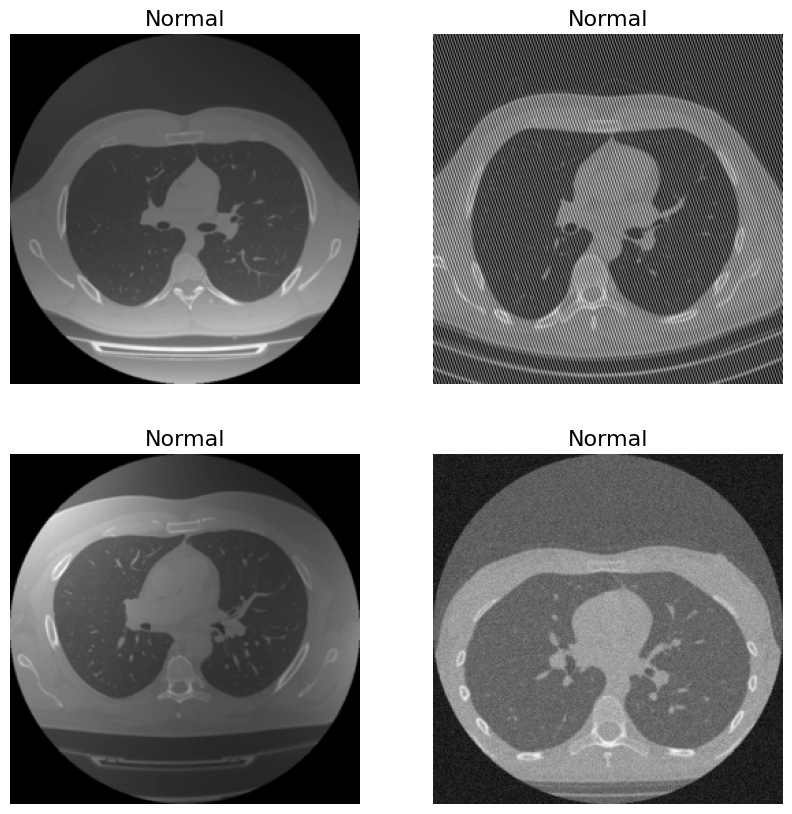

In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
image_size = 256
data_dir = "/tmp/curated_data/data"
batch_size = 16
data_dict = {x: CustomDataset(image_size, data_dir, x) for x in ["train", "val", "test"]}
img_data, lab_data = next(iter(data_dict["train"]))
print(img_data.shape, lab_data.shape)
dataloader_dict = {x: DataLoader(data_dict[x], batch_size) for x in ["train", "val", "test"]}
img, lab = next(iter(dataloader_dict["train"]))
print(img.shape, lab.shape)
label_dict = {
    0: "Normal",
    1: "Covid"
}
plt.figure(figsize=(10, 10))
for i in range(4):
  plt.subplot(2,2, i+1)
  plt.imshow(img[i, 0], cmap="gray")
  plt.title(label_dict[int(lab[i].item())], fontsize=16)
  plt.axis("off")
plt.show()

### 4. ResNet-18

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out, s, act):
      super(ConvBlock,self).__init__()
      # Initialize layers
      ##### START OF YOUR CODE #####
      activations = {'relu': torch.nn.ReLU(),
                     'leaky_relu': torch.nn.LeakyReLU(),
                     'gelu': torch.nn.GELU()}
      self.conv1 = nn.Conv2d(in_channels = ch_in, out_channels = ch_out, kernel_size = (1, 1), stride = (s, s))
      self.batch1 =  nn.BatchNorm2d(num_features  = ch_out)

      self.conv2 = nn.Conv2d(in_channels = ch_in, out_channels = ch_in, kernel_size = (3, 3), stride = (s, s), padding = (1, 1))
      self.batch2 = nn.BatchNorm2d(num_features  = ch_in)
      self.act1 = activations[act]
      self.conv3 = nn.Conv2d(in_channels = ch_in, out_channels = ch_out, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
      self.batch3 = nn.BatchNorm2d(num_features  = ch_out)
      self.act2 = activations[act]

      ##### END OF YOUR CODE #####

    def forward(self, X):
      ##### START OF YOUR CODE #####

      fx = self.conv2(X)
      fx = self.batch2(fx)
      fx = self.act1(fx)
      fx = self.conv3(fx)
      fx = self.batch3(fx)
      
      hx = self.conv1(X)
      hx = self.batch1(hx)
           
      X = hx + fx
      X = self.act2(X)
      ##### END OF YOUR CODE #####
      return X

class ResNet18(nn.Module):
    def __init__(self, act, drop_rate):
      super(ResNet18, self).__init__()
      # Initialize layers
      ##### START OF YOUR CODE #####
      # input: 16, 1, 256, 256 (batch size, channel, height, width) or 256 x 256 x 1
      activations = {'relu': torch.nn.ReLU(),
                     'leaky_relu': torch.nn.LeakyReLU(),
                     'gelu': torch.nn.GELU()}

      self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (7, 7), stride = (2, 2), padding = (3, 3)) # learnable parameters: 7*7*1*64 + 64 (bias) = 3200
      self.batch1 = nn.BatchNorm2d(num_features  = 64)
      self.act1 = activations[act]

      self.maxpool1 = nn.MaxPool2d(3, stride= 2, padding = (1, 1))
      self.conv21_x = ConvBlock(ch_in = 64, ch_out = 64, s = 1, act = act)
      self.conv22_x = ConvBlock(ch_in = 64, ch_out = 64, s = 1, act = act)

      self.conv31_x = ConvBlock(ch_in = 64, ch_out = 128, s = 2, act = act)
      self.conv32_x = ConvBlock(ch_in = 128, ch_out = 128, s = 1, act = act)

      self.conv41_x = ConvBlock(ch_in = 128, ch_out = 256, s = 2, act = act)
      self.conv42_x = ConvBlock(ch_in = 256, ch_out = 256, s = 1, act = act)

      self.conv51_x = ConvBlock(ch_in = 256, ch_out = 512, s = 2, act = act)
      self.conv52_x = ConvBlock(ch_in = 512, ch_out = 512, s = 1, act = act)

      self.fc = nn.Linear(512, 1)
      self.drop = torch.nn.Dropout(p=drop_rate)
      self.sg = nn.Sigmoid()

      ##### END OF YOUR CODE #####

    def forward(self, X):
      ##### START OF YOUR CODE #####
      
      # 256 x 256 x 1
      X = self.conv1(X)    # output: 128 x 128 x 64
      X = self.batch1(X)   # output: 128 x 128 x 64
      X = self.act1(X)     # output: 128 x 128 x 64
      X = self.maxpool1(X) # output: 64 x 64 x 64
      
      X = self.conv21_x(X)  # output: 64 x 64 x 64
      X = self.conv22_x(X)  # output: 64 x 64 x 64
      
      X = self.conv31_x(X)  # output: 32 x 32 x 64
      X = self.conv32_x(X)  # output: 32 x 32 x 128
    
      X = self.conv41_x(X)  # output: 16 x 16 x 128
      X = self.conv42_x(X)  # output: 16 x 16 x 256
   
      X = self.conv51_x(X)  # output: 8 x 8 x 256
      X = self.conv52_x(X)  # output: 8 x 8 x 512
      
      # (B, C, W, H) to (B, C, W * H)  
      X = nn.AvgPool2d(X.size(-1))(X)
      X = X.view(X.size(0), -1)
      X = self.drop(X) # drop out after average pooling.

      X = self.fc(X)
      X = self.sg(X)
      ##### END OF YOUR CODE #####
      return X

In [ ]:
from torchsummary import summary

device = torch.device('cuda')
model = ResNet18("relu", .5).to(device)
summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,200
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,928
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,928
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]           4,160
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
        ConvBlock-13           [-1, 64, 64, 64]               0
           Conv2d-14           [-1, 64,

# Assignment 3
<p>In this assignment you will

* write helper functions
* train the model
* hyperparameter search using W&B

Read the comments carefully and insert your code where you see: <br><br><b>##### START OF YOUR CODE #####</b><br><br><b>##### END OF YOUR CODE #####</b><br><br>or for the inline codes you will see<br><br><b>##### INSERT YOUR CODE HERE #####</b>

#### I. AverageMeter
First we will write a helper function. AverageMeter is to calculate the mean of the running loss and accuracy. 

*   It will have 2 functions which are reset and update.
*   reset will be called on initialization and set the attributes to 0. 
*   update takes 2 arguments for the value and the size. It will add the value to the sum and the size to the count. Attribute "avg" (use this name) will also be updated as sum/count.

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
      ##### START OF YOUR CODE #####
      self.avg = 0.0;
      self.count = 0.0
      self.sum = 0.0

    def reset(self):
      self.avg = 0.0
      self.sum = 0.0
      self.count = 0.0
    
    def update(self, value, size):
      self.sum += value * size
      self.count += size
      self.avg = self.sum / self.count
      
      ##### END OF YOUR CODE #####

In [ ]:
avg_meter = AverageMeter()
avg_meter.update(100, 5)
avg_meter.update(50, 5)
print(avg_meter.avg, avg_meter.count)

75.0 10.0


#### II. Train Loop
Now we will write the training and validation loops. Detailed instructions are given within the code.

In [ ]:
def training(train_loader, model, criterion, optimizer, device):
  # Let's start by initializing our AverageMeters.
  avg_meters = {'loss': AverageMeter(),
                'acc': AverageMeter()}

  # We will go through the train_loader.
  # Zero the gradients.
  # Make prediction.
  # Calculate the loss and the accuracy using prediction and labels.
  # Update the average meters.
  # Compute gradients and adjust learning weights.

  ##### START OF YOUR CODE #####
  # train_loader: DataLoader
  model.train()
  for img, lab in iter(train_loader):
    img = img.to(device)   # send input data to GPU
    lab = lab.to(device)   # send target labels to GPU
    optimizer.zero_grad()   # zero the gradients for every batch
    yhat = model(img)       # make predictions
    loss = criterion(yhat.to(torch.float32), lab.to(torch.float32))  # loss
    loss.backward()

    optimizer.step() # adjust learning weights
    yhat = yhat > 0.5
    correct = torch.eq(yhat, lab).sum().item()
    acc = (100.0 * correct) / lab.shape[0]
    avg_meters['loss'].update(loss.item(), 1)
    avg_meters['acc'].update(acc, 1)


  ##### END OF YOUR CODE #####

  return dict([('loss', avg_meters['loss'].avg),
                ('acc', avg_meters['acc'].avg)])

def validation(val_loader, model, criterion, device):
  avg_meters = {'loss': AverageMeter(),
                'acc': AverageMeter()}

  # Validation is almost the same but don't forget to turn the eval mode of the model and with torch no_grad.
  # You don't need to compute gradients or adjust learning weights for evaluation.

  ##### START OF YOUR CODE #####
  model.eval()
  with torch.no_grad():
    for img, lab in iter(val_loader):
      img = img.to(device)   # send input data to GPU
      lab = lab.to(device)   # send target labels to GPU
      yhat = model(img)
      
      loss = criterion(yhat.to(torch.float32), lab.to(torch.float32))
      yhat = yhat > 0.5
      correct = torch.eq(yhat, lab).sum().item()
      acc = (100.0 * correct) / lab.shape[0]
      avg_meters['loss'].update(loss.item(), 1)
      avg_meters['acc'].update(acc, 1)
 

  ##### END OF YOUR CODE #####

  return dict([('loss', avg_meters['loss'].avg),
              ('acc', avg_meters['acc'].avg)])

We will use Weights & Biases for hyperparameter search. This will only be an introduction and we highly recommend you to read the <a href="https://docs.wandb.ai/?_gl=1*1xon9b*_ga*NDg5OTYzNTM3LjE2NzUwNjYzNjk.*_ga_JH1SJHJQXJ*MTY3Njc0MDEyNi4xMi4xLjE2NzY3NDAxMjguNTguMC4w">documentation</a> for more information.

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=cae64af3eec54c06bde68f9ff06065c0f8c674908f31f644672e7dd690d0eb5e
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
from torch import optim
import wandb

def main():
  # Set the initial configuration
  initial_config = {
      "data_dir": "/tmp/curated_data/data/",
      "image_size": 128,
      "train_batch_size": 64,
      "val_batch_size": 32,
      "test_batch_size": 1,
      "activation": "relu",
      "drop_rate": .2,
      "optimizer": "Adam",
      "learning_rate": 1e-3,
      "l2_reg": 1e-4, # Weight decay
      "nb_epoch": 50,
      "early_stopping": 15, # trigger value for early stopping
  }

  # Using this configuration dictionary:
  # initialize wandb
  # Create a run directory in your drive ("/content/drive/MyDrive/CMPE_runs/" + the current run name that you'll get from wandb)
  # Create the model
  # Create dataloader dictionary with "train", "val", "test" keys
  # Define binary cross entropy loss
  # Define optimizer with weight decay
  # Set lr scheduler to ReduceLROnPlateau:
  # It will decrease the lr by .1 if the val_loss did not decrease > .01. The minimum lr value can be 1e-9.
  # Print train and val results and log them to wandb at the end of each epoch
  # Save best model weights to your run directory when the val accuracy is at least .01 better than the best val accuracy.
  # Set early stopping with the trigger in config["early_stopping"], monitoring val accuracy. config["early_stopping"] = -1 means no early stopping.
  # Print when a new model is saved or early stopping trigger is reached.
  # After the final epoch (or early stopping), load the best model weights and log the test results to wandb

  ##### START OF YOUR CODE #####
  assert wandb.run is None      # make sure that there is no active wandb session left
  run = wandb.init(config=initial_config)
  assert wandb.run is not None  # make sure that wandb is active
  
  run_directory = "/content/gdrive/MyDrive/CMPE_runs/" + run.name
  if not os.path.exists(run_directory):
    os.makedirs(run_directory)

  model = ResNet18(act = initial_config['activation'], drop_rate = initial_config['drop_rate']).to(device)

  data_dict = {x: CustomDataset(initial_config['image_size'], initial_config['data_dir'], x) for x in ["train", "val", "test"]}

  train2 = CustomDataset(initial_config['image_size'], initial_config['data_dir'], "train", augment = False)
  train3 = CustomDataset(initial_config['image_size'], initial_config['data_dir'], "train", augment = True, w = 1)
  data_dict['train'] = torch.utils.data.ConcatDataset([data_dict['train'], train2, train3])

  dataloader_dict = {x: DataLoader(data_dict[x], initial_config[x + '_batch_size']) for x in ["train", "val", "test"]}

  loss = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=initial_config['learning_rate'], weight_decay=initial_config['l2_reg'])
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr = 1e-9)

  wandb.watch(model)
  best_val_acc = None
  early_stop_counter = 0
  for epoch in range(initial_config['nb_epoch']):
    train = training(dataloader_dict['train'], model, loss, optimizer, device)
    train_loss, train_acc = train['loss'], train['acc']

    val = validation(dataloader_dict['val'], model, loss, device)
    val_loss, val_acc = val['loss'], val['acc']
    results = {
        'train_acc': train_acc,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'val_loss': val_loss
      }
    print(results)
    wandb.log(results)

    if(best_val_acc is None or best_val_acc + .01 < val_acc):
      best_val_acc = val_acc
      torch.save(model.state_dict(), os.path.join(run_directory, 'model.h5'))
      print("A new best model is saved at epoch {} with val accuracy: {}".format(epoch, best_val_acc))
      early_stop = 0
    else:
      early_stop += 1
      scheduler.step(val_loss)
      if initial_config['early_stopping'] > 0 and early_stop >= initial_config['early_stopping']:
        print("Early stopping triggered at epoch {}".format(epoch))
        break
  
  model.load_state_dict(torch.load(os.path.join(run_directory, 'model.h5')))

  test = validation(dataloader_dict['test'], model, loss, device)
  test_loss, test_acc = test['loss'], test['acc']
  wandb.log({
      'test_acc': test_acc,
      'test_loss': test_loss,
    })
  wandb.finish()

  ##### END OF YOUR CODE #####

In [ ]:
# Define the parameters that we will fine tune with, which are:
  # Activation function
  # Optimizer
  # Drop rate: should be chosen randomly from a uniform distribution between [0., 0.9]
  # Weight decay: should be chosen randomly from a uniform distribution between [0., 0.1]
  # Learning rate: should be chosen randomly from a uniform distribution between [0.0001, 0.1]
  
parameter_dict = {
    ##### START OF YOUR CODE #####
    'activation': {
        'values': ['relu', 'leaky_relu', 'gelu']
    },
    'optimizer': {
        'values': ['adam', 'sgd']
      },
    'dropout': {
        'distribution': 'uniform',
        'min': 0.,
        'max': 0.9
      },
    'weight_decay': {
        'distribution': 'uniform',
        'min': 0.,
        'max': 0.1
      },
    'learning_rate': {
        'distribution': 'uniform',
        'min': 0.0001,
        'max': 0.1
      },
    ##### END OF YOUR CODE #####
}

# Define a sweep configuration tells wandb that it will randomly choose from parameter dict and the purpose is to maximize val_accuracy
sweep_config = {
    ##### START OF YOUR CODE #####
    'method': 'random',
    'metric': {'goal': 'maximize', 'name': 'val_acc'}
    ##### END OF YOUR CODE #####
}
sweep_config['parameters'] = parameter_dict

# Start the sweep
sweep_id = wandb.sweep(sweep=sweep_config, project='CMPE58P Assignment-4 Part I')

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: bqmqqtzi
Sweep URL: https://wandb.ai/agape/CMPE58P%20Assignment-4%20Part%20I/sweeps/bqmqqtzi


In [ ]:
wandb.agent(sweep_id, function=main)

wandb: Agent Starting Run: 3foeayt1 with config:
wandb: 	activation: relu
wandb: 	dropout: 0.06684197403043066
wandb: 	learning_rate: 0.022899884677317985
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.037058502593823775
wandb: Currently logged in as: agape. Use `wandb login --relogin` to force relogin


{'train_acc': 80.16673102383054, 'train_loss': 0.45376463965015507, 'val_acc': 84.31919642857143, 'val_loss': 0.3964336311275309}
A new best model is saved at epoch 0 with val accuracy: 84.31919642857143
{'train_acc': 86.88561893203884, 'train_loss': 0.31717867075094897, 'val_acc': 77.93729707792208, 'val_loss': 0.4638433620672334}
{'train_acc': 89.95752427184466, 'train_loss': 0.24520148033077277, 'val_acc': 82.33056006493506, 'val_loss': 0.5157153291458433}
{'train_acc': 91.67930825242719, 'train_loss': 0.20385267974320545, 'val_acc': 84.56777597402596, 'val_loss': 0.467831545509398}
A new best model is saved at epoch 3 with val accuracy: 84.56777597402596
{'train_acc': 93.16595873786407, 'train_loss': 0.1732314592950697, 'val_acc': 82.45231331168831, 'val_loss': 0.5953139602629975}


wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
# You can have a look at the results from here: https://wandb.ai/agape/CMPE58P%20Assignment-4%20Part%20I/reports/CmpE58P-Assignment-4-Part-I-Data-Augmentation-and-Expansion--Vmlldzo0NDU3OTEx

In [ ]:
%%shell
jupyter nbconvert --to html ../content/CMPE_58P_Assignment4_Part_I.ipynb

[NbConvertApp] Converting notebook ../content/CMPE_58P_Assignment4_Part_I.ipynb to html
[NbConvertApp] Writing 1382246 bytes to ../content/CMPE_58P_Assignment4_Part_I.html
